In [10]:
import os
import matplotlib.pyplot as plt
from typing import Optional

def save_or_show_plot(output_file: Optional[str]) -> None:
    """
    Saves the plot to a PDF file if an output file path is provided, or displays the plot on screen if no file path is specified.
    
    Parameters:
        output_file (Optional[str]): The file path where the plot will be saved as a PDF. If None, the plot will be displayed using plt.show().
    
    Returns:
        None
    """
    if output_file is not None:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Save the figure as a PDF
        plt.savefig(output_file)
        plt.close()  # Close the plot to free up memory
    else:
        # Display the plot
        plt.show()


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from typing import Optional

def plot_heatmaps(results: pd.DataFrame, output_file: Optional[str] = "features/training/graphs/heatmaps.pdf") -> None:
    """
    Generates a series of heatmaps from a DataFrame containing model performance results, specifically
    plotting the accuracy of models across various configurations of 'max_depth' and 'n_estimators', grouped
    by combinations of 'min_samples_split', 'min_samples_leaf', and 'max_features'.

    Each heatmap corresponds to a specific combination of 'min_samples_split', 'min_samples_leaf',
    and 'max_features', showing how the accuracy varies with 'max_depth' and 'n_estimators'.

    Parameters:
        results (pd.DataFrame): A DataFrame containing the columns 'min_samples_split', 'min_samples_leaf',
                                'max_features', 'max_depth', 'n_estimators', and 'accuracy' that records
                                the accuracy of various RandomForest configurations.
        output_file (Optional[str]): The filename where the plot PDF will be saved. Defaults to 'features/training/graphs/heatmaps.pdf'.

    Returns:
        None: This function does not return any value but saves the heatmaps to a PDF file and displays them.
    """
    # Filter unique parameters for grouping
    unique_splits = results['min_samples_split'].unique()
    unique_leaves = results['min_samples_leaf'].unique()
    unique_features = results['max_features'].unique()

    # Prepare subplot grid layout
    num_plots = len(unique_splits) * len(unique_leaves) * len(unique_features)
    num_cols = 2  # Define number of columns in grid layout
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate needed rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

    # Ensure axes is a 2D array for easier indexing
    if num_rows == 1:
        axes = np.array([axes])

    idx = 0
    for split in unique_splits:
        for leaf in unique_leaves:
            for feature in unique_features:
                ax = axes[idx // num_cols, idx % num_cols]
                # Filter results for specific parameters
                subset = results[(results['min_samples_split'] == split) &
                                 (results['min_samples_leaf'] == leaf) &
                                 (results['max_features'] == feature)]
                # Pivot table for heatmap
                pivot_table = subset.pivot_table(values='accuracy', index='max_depth', columns='n_estimators')
                sns.heatmap(pivot_table, fmt=".2f", cmap='viridis', ax=ax)
                ax.set_title(f'Split: {split}, Leaf: {leaf}, Feature: {feature}')
                ax.set_xlabel('Number of Estimators')
                ax.set_ylabel('Max Depth')
                idx += 1

    # Adjust layout
    plt.tight_layout()
    
    # Output plot
    save_or_show_plot(output_file)


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Optional

def plot_parameter_effects(results: pd.DataFrame, output_file: Optional[str] = "features/training/graphs/boxplots.pdf") -> None:
    """
    Create box-and-whisker plots for each parameter against model accuracy. Box-and-whisker plots
    are used to show the distribution of the accuracy scores across different values of each parameter,
    providing insights into the median, quartiles, and outliers of the distributions.

    Parameters:
        results (pd.DataFrame): DataFrame containing model parameters and accuracies.
        output_file (Optional[str]): The path where the plot will be saved as a PDF file.

    Returns:
        None: This function does not return any value but saves the boxplots to a PDF file and displays them.
    """
    parameters = [col for col in results.columns if col != 'accuracy']
    n_plots = len(parameters)
    fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(10, 5 * n_plots))
    
    if n_plots == 1:
        axes = [axes]  # Make it iterable if there is only one plot
    
    for param, ax in zip(parameters, axes):
        # Use seaborn to create a box plot for each parameter
        sns.boxplot(data=results, x=param, y='accuracy', ax=ax)
        ax.set_title(f'Model Accuracy Distribution by {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Accuracy')
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    
    # Output plot
    save_or_show_plot(output_file)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Optional

def plot_accuracy_vs_estimators(results: pd.DataFrame, output_file: Optional[str] = "features/training/graphs/accuracy_vs_estimators.pdf") -> None:
    """
    Plots a scatter plot of model accuracy against the logarithm of the number of estimators ('n_estimators') used in the models,
    including a regression line to indicate the trend. The x-axis (number of estimators) is displayed on a logarithmic scale.

    Parameters:
        results (pd.DataFrame): DataFrame containing at least 'n_estimators' and 'accuracy'.
        output_file (Optional[str]): The path where the plot will be saved as a PDF file.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    # Create a copy of the DataFrame to ensure the original is not modified
    results_copy = results.copy()
    # Adjusting the x-axis to be logarithmic by adding a new column to the copy
    results_copy['log_n_estimators'] = np.log10(results_copy['n_estimators'])

    # Create scatter plot with regression line on the copied data
    sns.regplot(x='log_n_estimators', y='accuracy', data=results_copy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.title('Model Accuracy vs. Log of Number of Estimators')
    plt.xlabel('Log of Number of Estimators (log10)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Use the utility function to save or display the plot
    save_or_show_plot(output_file)

In [35]:
import pandas as pd
from typing import Dict, List

def select_best_parameters(results: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """
    Selects the best parameters for models based on different statistics of the 'accuracy' column:
    highest median, mean, first quartile (Q1), third quartile (Q3), and maximum accuracy.

    Parameters:
        results (pd.DataFrame): A DataFrame containing model parameters and their corresponding 'accuracy'.

    Returns:
        Dict[str, Dict[str, float]]: A dictionary where each key is a statistic ('median', 'mean', 'Q1', 'Q3', 'max')
                                     and the value is a dictionary of the parameters that maximize that statistic.
    """
    best_params = {
        'median': {},
        'mean': {},
        'Q1': {},
        'Q3': {},
        'max': {}
    }

    # Exclude 'accuracy' from parameter names
    parameter_names = results.columns.drop('accuracy')

    for stat in best_params.keys():
        # Group by each parameter and calculate the required statistic of 'accuracy'
        for param in parameter_names:
            grouped = results.groupby(param)['accuracy'].agg(['median', 'mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'max']).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'})
            if stat in ['median', 'mean', 'max']:
                best_value = grouped[stat].idxmax()
            else:
                best_value = grouped[stat].idxmax()
            best_params[stat][param] = best_value

    return best_params


In [28]:
# Path to the CSV file
csv_path = "features/training/results.csv"

# Load the data into a DataFrame
df = pd.read_csv(csv_path)

In [6]:
# Sort the DataFrame by accuracy in descending order and take the top 10
top_models = df.sort_values(by='accuracy', ascending=False).head(10)

# Display the top 10 models and their parameters
print(top_models)

      max_depth max_features  min_samples_leaf  min_samples_split  \
718           3         sqrt                 1                  5   
756           3         sqrt                 2                  2   
1002          3         log2                 4                  5   
5325         16         log2                 1                  5   
708           3         sqrt                 1                  5   
1857          6         sqrt                 4                  5   
928           3         log2                 2                  2   
1044          4         sqrt                 1                  2   
1204          4         log2                 1                  2   
1074          4         sqrt                 1                 10   

      n_estimators  accuracy  
718             16  0.709804  
756             16  0.705882  
1002            15  0.698039  
5325             6  0.698039  
708              6  0.698039  
1857            15  0.698039  
928             50  0.6

In [54]:
# plot_heatmaps(df)
plot_parameter_effects(df)
# plot_accuracy_vs_estimators(df)

In [36]:
best_params = select_best_parameters(df)
print(best_params)

{'median': {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}, 'mean': {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}, 'Q1': {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1000}, 'Q3': {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}, 'max': {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 16}}


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from typing import List, Dict, Any, Tuple

def load_and_prepare_data(features_path: str) -> pd.DataFrame:
    """
    Load and preprocess data from a specified file path.
    """
    data = pd.read_csv(features_path)
    features = ['hue', 'saturation', 'value', 'hsv_uniformity', 'compactness_score', 'Vertical Asymmetry_mean', 'Horizontal Asymmetry_mean']
    target = 'cancer'
    return data[features + [target]]

def evaluate_models(data: pd.DataFrame, best_params: Dict[str, Dict[str, Any]], random_state: int = 42) -> Dict[str, List[float]]:
    """
    Evaluates models based on provided best parameters and returns their performance.
    """
    results = {}
    # Iterate through each set of parameters (by statistic)
    for stat, params in best_params.items():
        model_accuracies = []
        for i in range(20):  # 20 different training/testing splits
            X_train, X_test, y_train, y_test = train_test_split(data.drop('cancer', axis=1), data['cancer'], test_size=0.20, random_state=random_state + i)
            model = RandomForestClassifier(**params)
            model.fit(X_train, y_train)
            accuracy = accuracy_score(y_test, model.predict(X_test))
            model_accuracies.append(accuracy)
        results[stat] = model_accuracies
    return results

# Assume 'best_params' is loaded or defined earlier in the notebook
# best_params example format: {'median': [{'max_depth': 10}], 'mean': [{'n_estimators': 100}]}

# Path to the dataset
features_path = "features/features.csv"

# Load and preprocess data
data = load_and_prepare_data(features_path)

# Evaluate models
evaluation_results = evaluate_models(data, best_params)

# Output or further analysis can go here, for example:
print(evaluation_results)

{'median': [0.6666666666666666, 0.6392156862745098, 0.615686274509804, 0.6313725490196078, 0.5843137254901961, 0.615686274509804, 0.6235294117647059, 0.6196078431372549, 0.615686274509804, 0.6235294117647059, 0.6588235294117647, 0.5843137254901961, 0.615686274509804, 0.6745098039215687, 0.5725490196078431, 0.6078431372549019, 0.6784313725490196, 0.6352941176470588, 0.5843137254901961, 0.5882352941176471], 'mean': [0.6745098039215687, 0.6392156862745098, 0.6235294117647059, 0.6274509803921569, 0.5882352941176471, 0.615686274509804, 0.6078431372549019, 0.6078431372549019, 0.615686274509804, 0.6313725490196078, 0.6588235294117647, 0.5843137254901961, 0.6078431372549019, 0.6784313725490196, 0.5803921568627451, 0.6039215686274509, 0.6705882352941176, 0.6392156862745098, 0.5843137254901961, 0.592156862745098], 'Q1': [0.6784313725490196, 0.6431372549019608, 0.615686274509804, 0.6352941176470588, 0.5882352941176471, 0.615686274509804, 0.6, 0.611764705882353, 0.615686274509804, 0.63529411764705

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, Optional

def plot_evaluation_results_boxplot(evaluation_results: Dict[str, List[float]], output_file: Optional[str] = None) -> None:
    """
    Plots box plots for model evaluation results, showing the distribution of accuracies for different
    statistical parameter optimization strategies (e.g., median, mean, Q1, Q3, max).

    Parameters:
        evaluation_results (Dict[str, List[float]]): A dictionary where keys are the statistics used to
                                                     optimize parameters and values are lists of accuracies.
        output_file (Optional[str]): The path where the plot will be saved as a PDF file. If None, the plot
                                     will be shown on screen.

    Returns:
        None
    """
    # Create a DataFrame for easier plotting with seaborn
    data = {key: pd.Series(value) for key, value in evaluation_results.items()}
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.title('Distribution of Model Accuracies by Parameter Optimization Strategy')
    plt.xlabel('Optimization Strategy')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Use utility function to save or display the plot
    save_or_show_plot(output_file)

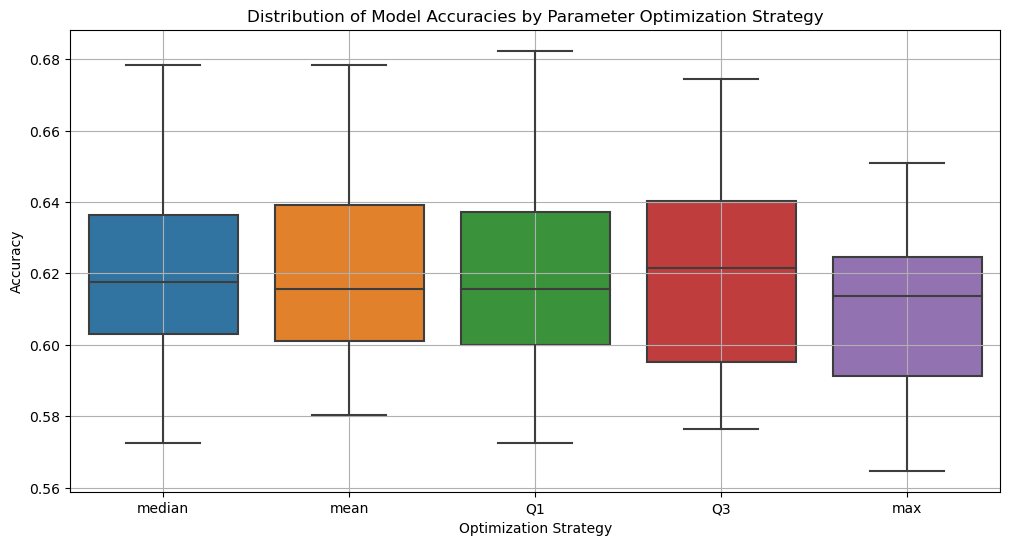

In [48]:
plot_evaluation_results_boxplot(evaluation_results)

In [49]:
from typing import Dict, List, Tuple, Any

def select_best_optimization_strategy(evaluation_results: Dict[str, List[float]], best_params: Dict[str, Dict[str, Any]]) -> Tuple[Dict[str, Any], float]:
    """
    Chooses the best optimization strategy based on the highest mean accuracy from evaluation results.

    Parameters:
        evaluation_results (Dict[str, List[float]]): A dictionary where keys are the statistics used to
                                                     optimize parameters (e.g., median, mean, Q1, Q3, max)
                                                     and values are lists of accuracies.
        best_params (Dict[str, Dict[str, Any]]): A dictionary containing the best parameters for each
                                                 optimization strategy.

    Returns:
        Tuple[Dict[str, Any], float]: A tuple containing the best parameters and the corresponding mean accuracy.
    """
    # Calculate the mean accuracy for each optimization strategy
    mean_accuracies = {stat: np.mean(acc) for stat, acc in evaluation_results.items()}
    
    # Determine the optimization strategy with the highest mean accuracy
    best_stat = max(mean_accuracies, key=mean_accuracies.get)
    best_accuracy = mean_accuracies[best_stat]
    best_parameters = best_params[best_stat]

    return (best_parameters, best_accuracy)

In [50]:
best_strategy, best_mean_accuracy = select_best_optimization_strategy(evaluation_results, best_params)
print("Best Strategy Parameters:", best_strategy)
print("Best Mean Accuracy:", best_mean_accuracy)

Best Strategy Parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1000}
Best Mean Accuracy: 0.6223529411764706


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import os
from typing import Dict, Any

def train_final_model(data: pd.DataFrame, best_strategy: Dict[str, Any], save_path: str) -> None:
    """
    Trains a RandomForest model using the best strategy parameters and saves the model to the specified path.

    Parameters:
        data (pd.DataFrame): The complete dataset including features and the target.
        best_strategy (Dict[str, Any]): The best parameters for training the RandomForest model.
        save_path (str): The file path where the trained model will be saved.

    Returns:
        None
    """
    # Split the data into features and target
    X = data.drop('cancer', axis=1)
    y = data['cancer']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # Initialize the RandomForest model with the best parameters
    model = RandomForestClassifier(**best_strategy)
    
    # Train the model
    model.fit(X_train, y_train)
    
    accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"Accuracy of the final model: {accuracy:.2f}")
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the trained model
    joblib.dump(model, save_path)
    print(f"Model saved to {save_path}")

# Example usage:
# data = pd.read_csv('path_to_your_data.csv')
# best_strategy = {'n_estimators': 150, 'max_depth': 10, 'random_state': 42}
# save_path = 'path_to_save_your_model/final_model.pkl'
# train_final_model(data, best_strategy, save_path)

In [52]:
train_final_model(data, best_strategy, "features/training/final_model")

Accuracy of the final model: 0.67
Model saved to features/training/final_model
